# Data loading

In [1]:
import copy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
jar = pd.read_csv('fuel_swelling_20240109.txt', sep=' ')
columns_drop = ['%eval_id', 'interface', 'FD1', 'FD2', 'FD3', 'fuel_swelling1', 'fuel_swelling2']
jar.drop(columns=columns_drop, inplace=True)

In [3]:
jar

,dGrainHBS,FaceCovMax,SwellLink,vResol,DatomFissGBx,fNucleate,aAtomDifFiss,fuel_swelling3
0,0.000044,0.725,0.02270,1.907000e-18,29010.0,6.315000e-10,5.296000e-31,44.947087
1,0.000048,0.899,0.02587,2.074000e-18,28080.0,6.653000e-10,5.740000e-31,42.531250
2,0.000045,0.835,0.02241,2.134000e-18,35430.0,6.577000e-10,5.252000e-31,42.858313
3,0.000046,0.628,0.02796,1.870000e-18,31140.0,5.596000e-10,5.104000e-31,47.988939
4,0.000042,0.725,0.02707,1.696000e-18,27470.0,6.026000e-10,5.070000e-31,43.136858
...,...,...,...,...,...,...,...,...
3195,0.000038,0.787,0.02303,2.002000e-18,28810.0,5.710000e-10,4.533000e-31,39.049876
3196,0.000039,0.743,0.02428,1.664000e-18,24780.0,6.381000e-10,5.127000e-31,41.342469
3197,0.000038,0.800,0.02456,1.751000e-18,31310.0,5.117000e-10,5.247000e-31,39.040535
3198,0.000046,0.795,0.02365,2.136000e-18,36170.0,5.038000e-10,5.705000e-31,44.282862


<Axes: >

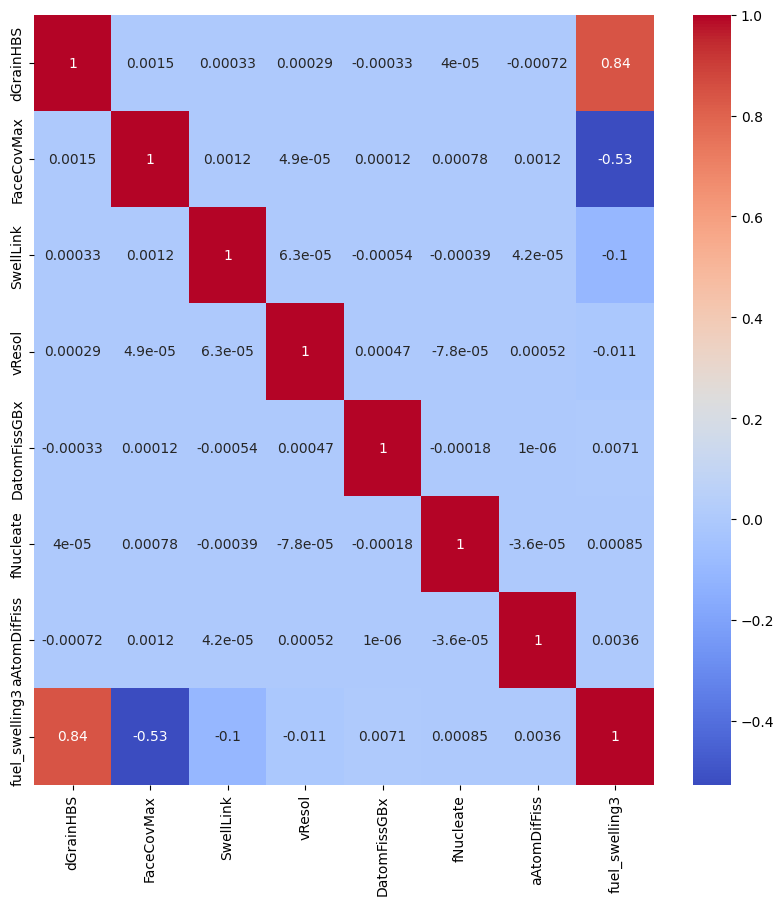

In [4]:
plt.figure(figsize=(10,10))
sns.heatmap(jar.corr(), annot=True, cmap='coolwarm')

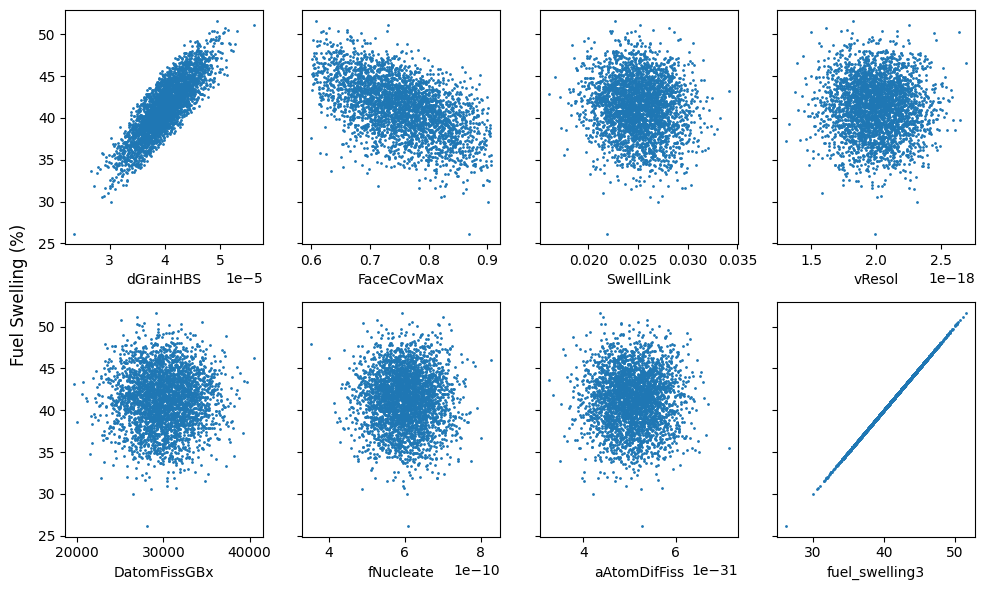

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()):
    ax.scatter(jar.iloc[:,i], jar.iloc[:,7], s=1)
    ax.set_xlabel(jar.columns[i])
    #ax.set_ylabel(jar.columns[-1])

fig.supylabel('Fuel Swelling (%)')
plt.tight_layout()
plt.show()

# Linear

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [7]:
feat_ind = list(range(7))
features = jar.iloc[:, feat_ind]
xscaler = StandardScaler()
X = xscaler.fit_transform(features)
y = jar['fuel_swelling3']

In [8]:
reg = LinearRegression().fit(X, y)

In [9]:
reg.score(X, y)

0.996884663293091

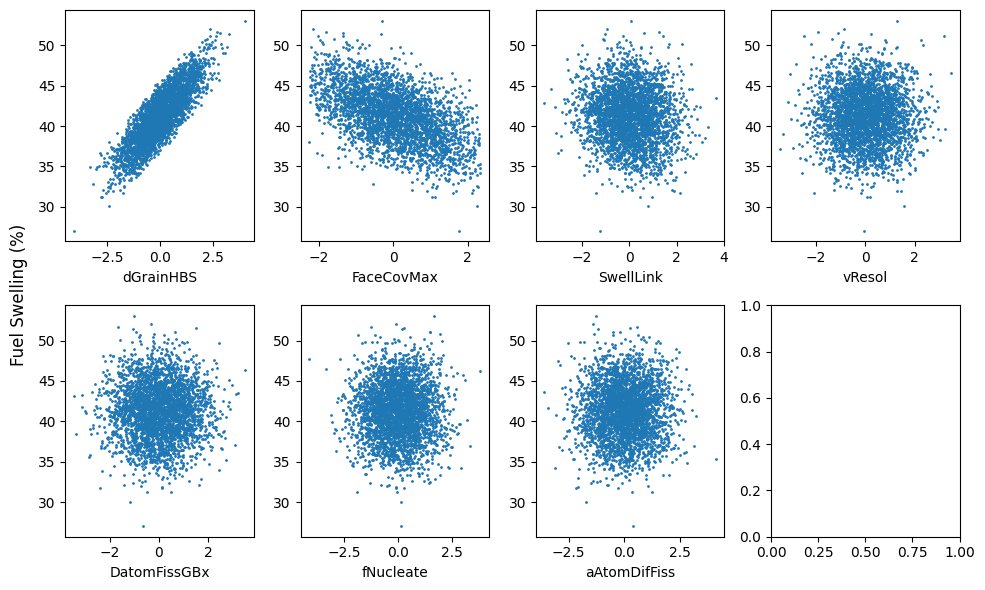

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

y_pred = reg.predict(X)
for i, ax in enumerate(axes.flatten()[:-1]):
    ax.scatter(X[:,i], y_pred, s=1)
    ax.set_xlabel(jar.columns[i])

fig.supylabel('Fuel Swelling (%)')
plt.tight_layout()
plt.show()

In [11]:
reg.coef_

array([ 2.82724374, -1.77142238, -0.35113877, -0.03660669,  0.02490697,
        0.00399536,  0.01631501])

In [12]:
from sklearn.metrics import r2_score
r2_score(y, y_pred)

0.996884663293091

# MCMC

In [13]:
def target_dist(x):
    mu = 45
    sig = 2
    return np.exp(-0.5 * ((x-mu)/sig)**2)

def candidate_dist(x, sig=0.5):
    return np.random.normal(x, sig)
    
def mod_mcmc_sampler(num_param, num_samples, initial_state, proposal_sigma, model):
    samples = [initial_state]

    for ii in range(num_samples):
        current_state = samples[-1]
        
        for jj in range(num_param):
            current_p = current_state[jj]
            proposed_p = 10
            while (abs(proposed_p) > 5):
                proposed_p = candidate_dist(current_p, proposal_sigma)

            proposed_state = copy.deepcopy(current_state)
            proposed_state[jj] = proposed_p
            theta1 = model.predict([[*current_state]])[0]
            theta2 = model.predict([[*proposed_state]])[0]

            #acceptance_ratio = target_dist(proposed_state) / target_dist(current_state)
            acceptance_ratio = target_dist(theta2) / target_dist(theta1)

            if np.random.rand() < acceptance_ratio:
                current_state = proposed_state

        samples.append(current_state)

    return np.array(samples)

In [14]:
hey = mod_mcmc_sampler(7, 50000, np.zeros(7), 0.3, reg)

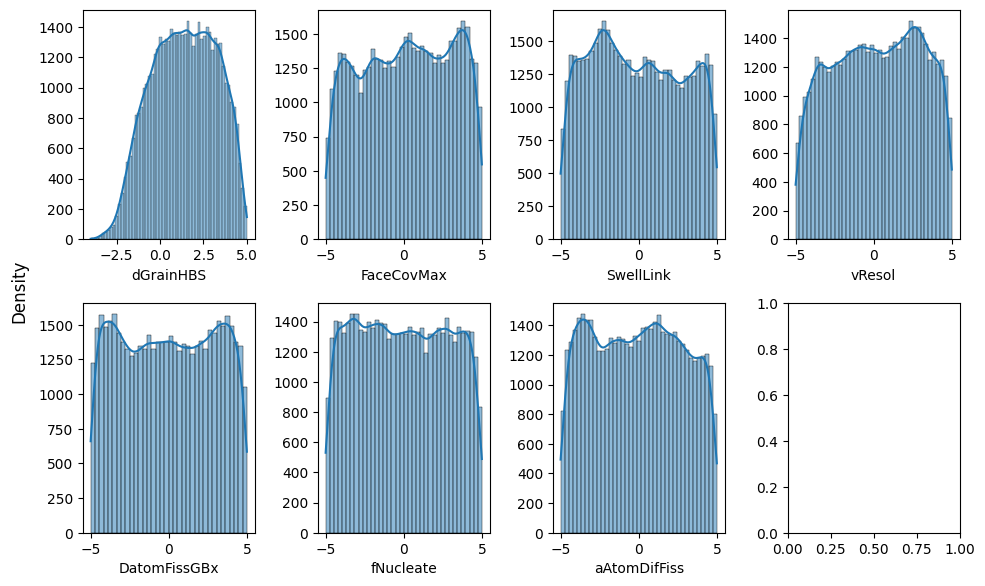

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    sns.histplot(hey[:,i], ax=ax, kde=True)
    ax.set_xlabel(jar.columns[i])
    ax.set_ylabel('')

fig.supylabel('Density')
plt.tight_layout()
plt.show()

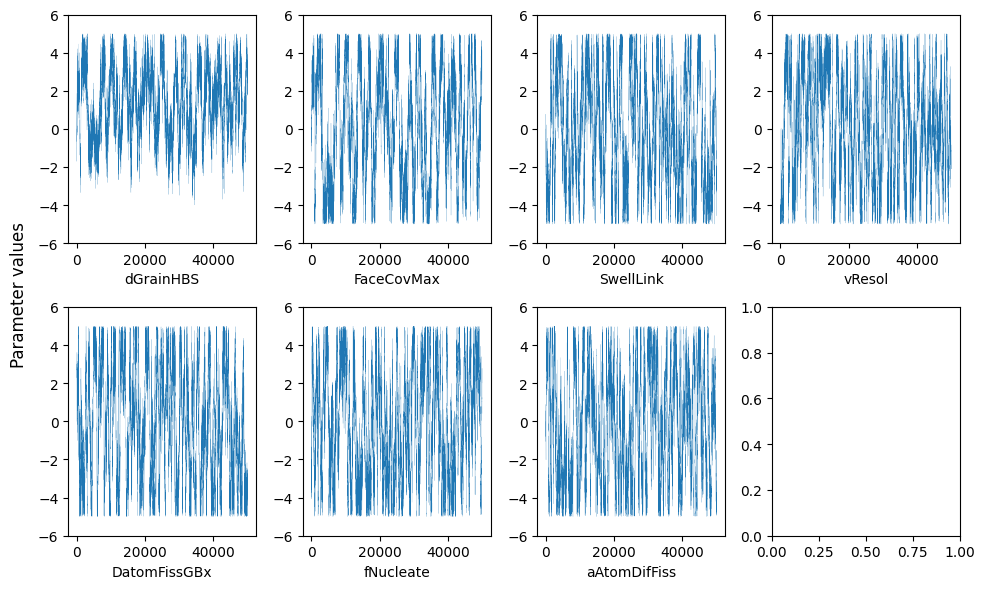

In [16]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10, 6))

for i, ax in enumerate(axes.flatten()[:-1]):
    ax.plot(hey[:,i], lw=0.1)
    ax.set_xlabel(jar.columns[i])
    ax.set_ylim([-6, 6])

fig.supylabel('Parameter values')
plt.tight_layout()
plt.show()